In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'improved_ff/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

FF = imp.load_source('FF_functions',lib_function_dir+'FF_functions.py')

Welcome to JupyROOT 6.18/04
N_tot =  4.10331109202e+31   flux=  1.58051463543e+11 for pot:  2.144e+20


In [2]:
outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)

In [3]:
'''
FF functions:

main_plot(h_this)
arr2plot(this_arr)
plot2arr(h_this_tmp, dim)
histBkg(hist)
plot_err_array(this_arr)
draw_adding()
draw_sim()
cov2corr(this_covar)
frac2cov(frac, pred)

'''

'\nFF functions:\n\nmain_plot(h_this)\narr2plot(this_arr)\nplot2arr(h_this_tmp, dim)\nhistBkg(hist)\nplot_err_array(this_arr)\ndraw_adding()\ndraw_sim()\ncov2corr(this_covar)\nfrac2cov(frac, pred)\n\n'

In [4]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kFALSE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [5]:
from array import array
#mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#mom_bins = [ 0.00, 0.225, 0.28, 0.33, 0.39, 0.52, 0.78, 1.21, 2.5]

mom_bins = {}
#mom_bins.Append()
mom_bins[0] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[1] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[2] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[3] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[4] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[5] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[6] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[7] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[8] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]

theta_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]

len_theta = len(theta_bins) - 1
len_mom = {}
sum_bins = 0
for i in range(len_theta):
    len_mom[i] = len(mom_bins[i]) - 1
    #print len_mom[i]
    sum_bins+=len_mom[i]


In [6]:
NumberOfFiles = 5000
POT_file = 5e8
activeVol_Area = 128.175*2*116.5*2
pot_data = 2.144e+20

path = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/Flux/zarko/'
f_flux_int = ROOT.TFile.Open(path+"MCC9_FluxHist_volTPCActive.root", 'read')
h_flux_cv = f_flux_int.Get("hEnumu_cv")
flux_cv = h_flux_cv.Integral(-1,201)/(NumberOfFiles*POT_file*activeVol_Area)*pot_data

roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))

N_tot = roh_data*N_A*N_nucleons*V_fid/mol

print 'N_tot = ',N_tot,'  flux= ',flux_cv, 'for pot: ', pot_data

N_tot =  4.10331109202e+31   flux=  1.58051463543e+11 for pot:  2.144e+20


# prepare systematics

Make numpy files including the backbgrounds and smearing matices for the different systematics:
detector, genie_all, genie_other, flux

What is needed is per universe: background, smearing matrix


# Detector systematic

Detector systematic: 1 universe, 1 sigma
Effects: cv, dedx, LYatt, LYdown, LYray, recomb2, SCE, WireAngleXZ, WireAngleYZ, WireModX, WireModYZ

In [7]:
#store all histograms needed in one file: bkg, smearing, covariance
if(1):
    path_detsys = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'

    f_cv = ROOT.TFile.Open(path_detsys+'xsec_detsys_CV_2D_t/xsec_detsys_CV_2D.root', 'read')
    f_dedx = ROOT.TFile.Open(path_detsys+'xsec_detsys_dEdx_2D_t/xsec_detsys_dEdx_2D.root', 'read')
    f_LYatt = ROOT.TFile.Open(path_detsys+'xsec_detsys_LYAtt_2D_t/xsec_detsys_LYAtt_2D.root', 'read')
    f_LYdown = ROOT.TFile.Open(path_detsys+'xsec_detsys_LYdown_2D_t/xsec_detsys_LYdown_2D.root', 'read')
    f_LYray = ROOT.TFile.Open(path_detsys+'xsec_detsys_LYRay_2D_t/xsec_detsys_LYRayleigh_2D.root', 'read')
    f_recomb2 = ROOT.TFile.Open(path_detsys+'xsec_detsys_recomb2_2D_t/xsec_detsys_recomb2_2D.root', 'read')
    f_sce = ROOT.TFile.Open(path_detsys+'xsec_detsys_SCE_2D_t/xsec_detsys_SCE_2D.root', 'read')
    f_waxz = ROOT.TFile.Open(path_detsys+'xsec_detsys_WireAngleXZ_2D_t/xsec_detsys_WireAngleXZ_2D.root', 'read')
    f_wayz = ROOT.TFile.Open(path_detsys+'xsec_detsys_WireAngleYZ_2D_t/xsec_detsys_WireAngleYZ_2D.root', 'read')
    f_wmx = ROOT.TFile.Open(path_detsys+'xsec_detsys_WireModX_2D_t/xsec_detsys_WireModX_2D.root', 'read')
    f_wmyz = ROOT.TFile.Open(path_detsys+'xsec_detsys_WireModYZ_2D_t/xsec_detsys_WireModYZ_2D.root', 'read')

    f_all = ROOT.TFile.Open(path_detsys+'xsec_detsys_all_2D_t/Detector_systematic_2D.root', 'read')
    
    h_true_cv = f_cv.Get('h_gen_all')
    h_sel_cv = f_cv.Get('h_sel_all')

    h_ext_cv = f_cv.Get('h_ext_all')
    h_dirt_cv = f_cv.Get('h_dirt_all')


    h_bkg_cv = f_cv.Get('h_bkg_all')
    h_bkg_dedx = f_dedx.Get('h_bkg_all')
    h_bkg_LYatt = f_LYatt.Get('h_bkg_all')
    h_bkg_LYdown = f_LYdown.Get('h_bkg_all')
    h_bkg_LYray = f_LYray.Get('h_bkg_all')
    h_bkg_recomb2 = f_recomb2.Get('h_bkg_all')
    h_bkg_sce = f_sce.Get('h_bkg_all')
    h_bkg_waxz = f_waxz.Get('h_bkg_all')
    h_bkg_wayz = f_wayz.Get('h_bkg_all')
    h_bkg_wmx = f_wmx.Get('h_bkg_all')
    h_bkg_wmyz = f_wmyz.Get('h_bkg_all')

    h_smear_cv = f_cv.Get('h_smearing')
    h_smear_dedx = f_dedx.Get('h_smearing')
    h_smear_LYatt = f_LYatt.Get('h_smearing')
    h_smear_LYdown = f_LYdown.Get('h_smearing')
    h_smear_LYray = f_LYray.Get('h_smearing')
    h_smear_recomb2 = f_recomb2.Get('h_smearing')
    h_smear_sce = f_sce.Get('h_smearing')
    h_smear_waxz = f_waxz.Get('h_smearing')
    h_smear_wayz = f_wayz.Get('h_smearing')
    h_smear_wmx = f_wmx.Get('h_smearing')
    h_smear_wmyz = f_wmyz.Get('h_smearing')

    #save all whats needed
    RootFile = ROOT.TFile('/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/'+"FF_detsys.root","RECREATE");
    #blbla.Write('dfdfs')
    h_true_cv.Write('h_true_cv')
    h_sel_cv.Write('h_sel_cv')
    
    h_ext_cv.Write('h_ext_cv')
    h_dirt_cv.Write('h_dirt_cv')

    h_bkg_cv.Write('h_bkg_cv')
    h_bkg_dedx.Write('h_bkg_dedx')
    h_bkg_LYatt.Write('h_bkg_LYatt')
    h_bkg_LYdown.Write('h_bkg_LYdown')
    h_bkg_LYray.Write('h_bkg_LYray')
    h_bkg_recomb2.Write('h_bkg_recomb2')
    h_bkg_sce.Write('h_bkg_sce')
    h_bkg_waxz.Write('h_bkg_waxz')
    h_bkg_wayz.Write('h_bkg_wayz')
    h_bkg_wmx.Write('h_bkg_wmx')
    h_bkg_wmyz.Write('h_bkg_wmyz')

    h_smear_cv.Write('h_smear_cv')
    h_smear_dedx.Write('h_smear_dedx')
    h_smear_LYatt.Write('h_smear_LYatt')
    h_smear_LYdown.Write('h_smear_LYdown')
    h_smear_LYray.Write('h_smear_LYray')
    h_smear_recomb2.Write('h_smear_recomb2')
    h_smear_sce.Write('h_smear_sce')
    h_smear_waxz.Write('h_smear_waxz')
    h_smear_wayz.Write('h_smear_wayz')
    h_smear_wmx.Write('h_smear_wmx')
    h_smear_wmyz.Write('h_smear_wmyz')

    RootFile.Close()

In [8]:
def smear_plot(h_true):
    if h_true.GetNbinsX() != 43:
        h_true_this = ROOT.TH1F('h_true_this',"h_true_this",43,0,43)
        for i in range(43):
            h_true_this.SetBinContent(i+1,h_true.GetBinContent(i+1))
    else:
        h_true_this = h_true.Clone()
    h_smear = f_cv.Get('h_smearing')
    smear_mat = FF.plot2arr(h_smear,2)
    eff_vec = FF.plot2arr(h_eff,1)
    true_vec = FF.plot2arr(h_true_this,1)
    smear_mat = smear_mat.T*eff_vec
    reco_vec = smear_mat.dot(true_vec)
    h_reco = FF.arr2plot(reco_vec)
    
    return h_reco

In [9]:
def return_detsys_covar(h_true,this_pot):
    #print 'go into function'
    #calculate the covariance for the the prediction
    path_this = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/'
    f_this = ROOT.TFile.Open(path_this+'FF_detsys.root', 'read')
    para = ['dedx','LYatt','LYdown','LYray','recomb2','sce','waxz','wayz','wmx','wmyz']
    #print 'Opend file'
    h_true_cv = h_true.Clone()
    h_ext_cv = f_this.Get('h_ext_cv')
    h_dirt_cv = f_this.Get('h_dirt_cv')
    h_bkg_cv = f_this.Get('h_bkg_cv')
    h_ext_cv.Scale(this_pot/9.457e+18)
    h_dirt_cv.Scale(this_pot/9.457e+18)
    h_bkg_cv.Scale(this_pot/9.457e+18)
    h_smear_cv = f_this.Get('h_smear_cv')
    num_bins = h_smear_cv.GetNbinsX()
    smear_mat = np.zeros((num_bins,num_bins))
    true_vec = np.zeros((num_bins))
    bkg_vec = np.zeros((num_bins))
    ext_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))

    for i in range(num_bins):
        true_vec[i] = h_true_cv.GetBinContent(i+1)
        bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)
        ext_vec[i] = h_ext_cv.GetBinContent(i+1)
        dirt_vec[i] = h_dirt_cv.GetBinContent(i+1)
        for j in range(num_bins):
            smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)
    #print 'filled vecotrs'
    reco_vec = true_vec.dot(smear_mat)

    bkg_vec_det = np.zeros((len(para),num_bins))
    reco_vec_det = np.zeros((len(para),num_bins))
    smear_mat_det = np.zeros((len(para),num_bins,num_bins))

    #sig_vec_det = np.zeros((len(para),num_bins)) # signal + bkg prediction
    res_vec_det = np.zeros((len(para),num_bins)) # residual
    res_vec = np.zeros((num_bins)) # quadratic sum


    h_bkg_det = []
    h_smear_det = []
    #print 'go into loop'
    for i,x in enumerate(para):
        h_bkg_det.append(f_this.Get('h_bkg_'+x))
        h_bkg_det[i].Scale(this_pot/9.457e18)
        h_smear_det.append(f_this.Get('h_smear_'+x))
        for j in range(num_bins):
            bkg_vec_det[i][j] = h_bkg_det[i].GetBinContent(j+1)
            for k in range(num_bins):
                smear_mat_det[i][j][k] = h_smear_det[i].GetBinContent(j+1,k+1)
        reco_vec_det[i]= true_vec.dot(smear_mat_det[i])
        #print reco_vec[1]+bkg_vec[1], reco_vec_det[i][1] + bkg_vec_det[i][1]
        res_vec_det[i] = ((reco_vec+bkg_vec) - (reco_vec_det[i] + bkg_vec_det[i]))/(reco_vec+bkg_vec+ext_vec+dirt_vec)

        for j in range(num_bins):
            res_vec[j] += res_vec_det[i][j]*res_vec_det[i][j]

    frac_covar_det = np.zeros((num_bins,num_bins))
    for i,x in enumerate(para):
        for j in range(num_bins):
            for k in range(num_bins):
                frac_covar_det[j][k] += res_vec_det[i][j] * res_vec_det[i][k]

    return frac_covar_det

In [34]:
def return_other_covar(h_true,this_pot):
    weight_list = [ 'AxFFCCQEshape_UBGenie' , 'DecayAngMEC_UBGenie', 'NormCCCOH_UBGenie', 'NormNCCOH_UBGenie',\
                   'RPA_CCQE_Reduced_UBGenie','RPA_CCQE_UBGenie','ThetaDelta2NRad_UBGenie','Theta_Delta2Npi_UBGenie',\
                    'VecFFCCQEshape_UBGenie','XSecShape_CCMEC_UBGenie']
    w_list = [0,1,2,3,4,5,6,7,8,9]
    
    path_other = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/pc46_data/'
    f_other = ROOT.TFile.Open(path_other+'Other_Genie_2D.root', 'read')

    h_true_cv = h_true.Clone()
    num_bins = h_true_cv.GetNbinsX()
    frac_covar = np.zeros((num_bins,num_bins))
    
    path_ext = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
    f_ext = ROOT.TFile.Open(path_ext+'xsec_2D_Run3_wighted.root', 'read')
    h_ext = ROOT.TH1F('h_ext',"Cosmic",43,0,43)
    h_dirt = ROOT.TH1F('h_dirt',"Cosmic",43,0,43)
    bin_counter = 0
    for t_bin in range(len_theta): #len_theta
        h_temp4 = f_cv.Get('h_ext['+str(t_bin)+']')
        h_temp5 = f_cv.Get('h_dirt['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
            h_dirt.SetBinContent(bin_counter,h_temp5.GetBinContent(m_bin+1))
    h_ext.Scale(this_pot/2.144e+20)
    h_dirt.Scale(this_pot/2.144e+20)
    
    ext_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))
    
    for i in range(num_bins):
        ext_vec[i] = h_ext.GetBinContent(i+1)
        dirt_vec[i] = h_dirt.GetBinContent(i+1)
        
    for w in w_list:
        #take first uiverse as cv
        h_bkg_cv = f_other.Get('h_bkg_all['+str(w)+'][0]')
        h_bkg_cv.Scale(this_pot/7.644e+18)
        h_smear_cv = f_other.Get('h_smearing['+str(w)+'][0]')
        h_eff_cv = f_other.Get('h_eff_all['+str(w)+'][0]')
        h_eff_cv.SetBinContent(5,1)
        h_eff_cv.SetBinContent(10,1)

        h_bkg_1 = f_other.Get('h_bkg_all['+str(w)+'][1]')
        h_bkg_1.Scale(this_pot/7.644e+18)
        h_smear_1 = f_other.Get('h_smearing['+str(w)+'][1]')
        h_eff_1 = f_other.Get('h_eff_all['+str(w)+'][1]')
        h_eff_1.SetBinContent(5,1)
        h_eff_1.SetBinContent(10,1)

        smear_mat = np.zeros((num_bins,num_bins))
        true_vec = np.zeros((num_bins))
        bkg_vec = np.zeros((num_bins))

        smear_mat1 = np.zeros((num_bins,num_bins))
        bkg_vec1 = np.zeros((num_bins))

        for i in range(num_bins):
            true_vec[i] = h_true_cv.GetBinContent(i+1)
            bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)

            bkg_vec1[i] = h_bkg_1.GetBinContent(i+1)
            for j in range(num_bins):
                smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)*h_eff_cv.GetBinContent(j+1)
                smear_mat1[i][j]= h_smear_1.GetBinContent(i+1,j+1)*h_eff_1.GetBinContent(j+1)

        reco_vec = true_vec.dot(smear_mat)
        reco_vec1 = true_vec.dot(smear_mat1)

        res_vec_other = ((reco_vec+bkg_vec) - (reco_vec1 + bkg_vec1))/(reco_vec+bkg_vec+ext_vec+dirt_vec)
        frac_covar_other = np.zeros((num_bins,num_bins))
        for j in range(num_bins):
            for k in range(num_bins):
                frac_covar_other[j][k] += res_vec_other[j] * res_vec_other[k]

        frac_covar += frac_covar_other
    return frac_covar


In [47]:
def return_all_covar(h_true,this_pot):
    path_all = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/pc46_data/'
    f_all = ROOT.TFile.Open(path_all+'All_Genie_2D.root', 'read')
    
    h_true_cv = h_true.Clone()
    h_bkg_cv = f_all.Get('h_bkg_all[0]')
    bin_counter=0
    for t_bin in range(len_theta): #len_theta
        h_temp = f_all.Get('h_overlay_cv['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_bkg_cv.SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))

    h_bkg_cv.Scale(this_pot/7.644e+18)
    h_smear_cv = f_all.Get('h_smearing_cv')
    h_eff_cv = f_all.Get('h_eff_all_cv')
    h_eff_cv.SetBinContent(5,1)
    h_eff_cv.SetBinContent(10,1)
    
    path_ext = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
    f_ext = ROOT.TFile.Open(path_ext+'xsec_2D_Run3_wighted.root', 'read')
    h_ext = ROOT.TH1F('h_ext',"Cosmic",43,0,43)
    h_dirt = ROOT.TH1F('h_dirt',"Cosmic",43,0,43)
    bin_counter = 0
    for t_bin in range(len_theta): #len_theta
        h_temp4 = f_cv.Get('h_ext['+str(t_bin)+']')
        h_temp5 = f_cv.Get('h_dirt['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
            h_dirt.SetBinContent(bin_counter,h_temp5.GetBinContent(m_bin+1))
    h_ext.Scale(this_pot/2.144e+20)
    h_dirt.Scale(this_pot/2.144e+20)

    num_bins = h_smear_cv.GetNbinsX()
    smear_mat = np.zeros((num_bins,num_bins))
    true_vec = np.zeros((num_bins))
    bkg_vec = np.zeros((num_bins))
    ext_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))

    for i in range(num_bins):
        true_vec[i] = h_true_cv.GetBinContent(i+1)
        bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)
        ext_vec[i] = h_ext.GetBinContent(i+1)
        dirt_vec[i] = h_dirt.GetBinContent(i+1)
        for j in range(num_bins):
            smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)*h_eff_cv.GetBinContent(j+1)

    reco_vec = true_vec.dot(smear_mat)
    
    num_universe = 100

    bkg_vec_all = np.zeros((num_universe,num_bins))
    reco_vec_all = np.zeros((num_universe,num_bins))
    smear_mat_all = np.zeros((num_universe,num_bins,num_bins))

    res_vec_all = np.zeros((num_universe,num_bins))

    h_bkg_all = []
    h_smear_all = []
    h_eff_all = []
    for uni in range(num_universe):
        #do something
        h_bkg_all.append(f_all.Get('h_bkg_all['+str(0)+']'))
        bin_counter = 0
        for t_bin in range(len_theta): #len_theta
            h_temp = f_all.Get('h_overlay['+str(uni)+']['+str(t_bin)+']')
            for m_bin in range(len_mom[t_bin]):
                bin_counter+=1
                h_bkg_all[uni].SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))
            del h_temp

        h_bkg_all[uni].Scale(this_pot/7.644e+18)
        h_smear_all.append(f_all.Get('h_smearing['+str(uni)+']'))
        h_eff_all.append(f_all.Get('h_eff_all['+str(uni)+']'))
        h_eff_all[uni].SetBinContent(5,1)
        h_eff_all[uni].SetBinContent(10,1)

        for j in range(num_bins):
            bkg_vec_all[uni][j] = h_bkg_all[uni].GetBinContent(j+1)
            for k in range(num_bins):
                smear_mat_all[uni][j][k] = h_smear_all[uni].GetBinContent(j+1,k+1)*h_eff_all[uni].GetBinContent(k+1)
        reco_vec_all[uni]= true_vec.dot(smear_mat_all[uni])
        res_vec_all[uni] = ((reco_vec+bkg_vec) - (reco_vec_all[uni] + bkg_vec_all[uni]))/(reco_vec+bkg_vec+ext_vec+dirt_vec)

    frac_covar_all = np.zeros((num_bins,num_bins))
    for uni in range(num_universe):
        for j in range(num_bins):
            for k in range(num_bins):
                frac_covar_all[j][k] += res_vec_all[uni][j] * res_vec_all[uni][k]
    frac_covar_all = frac_covar_all/num_universe
    
    del h_bkg_all
    del h_smear_all
    del h_eff_all
    
    return frac_covar_all

In [83]:
def return_flux_covar(h_true,this_pot):
    # give h_true_cv and POT since bkg is for specific POT
    # BACKGROUND, EFFICIENCY ARE IN ONE FILE, SMEARING IN OTHER...
    path = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/Flux/zarko/'
    path_flux = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/pc46_data/'

    #weight_list = [ 'expskin_FluxUnisim', 'horncurrent_FluxUnisim' ]
    weight_list = [ 'expskin_FluxUnisim', 'horncurrent_FluxUnisim', 'kminus_PrimaryHadronNormalization', 'kplus_PrimaryHadronFeynmanScaling',\
        'kzero_PrimaryHadronSanfordWang', 'nucleoninexsec_FluxUnisim', 'nucleonqexsec_FluxUnisim', 'nucleontotxsec_FluxUnisim',\
        'piminus_PrimaryHadronSWCentralSplineVariation', 'pioninexsec_FluxUnisim', 'pionqexsec_FluxUnisim', 'piontotxsec_FluxUnisim',\
        'piplus_PrimaryHadronSWCentralSplineVariation' ]

    f_flux_int = ROOT.TFile.Open(path+"MCC9_FluxHist_volTPCActive.root", 'read')

    f_flux_smear = []
    f_flux_bkg = []
    for i,x in enumerate(weight_list):
        f_flux_smear.append(ROOT.TFile.Open(path_flux+'xsec_2d_flux/root_output/'+x+'_Flux_systematic.root', 'read'))
        f_flux_bkg.append(ROOT.TFile.Open(path_flux+'xsec_2d_flux_rest/root_output/'+x+'_Flux_systematic_rest.root', 'read'))

    h_true_cv = h_true.Clone()
    num_bins = h_true_cv.GetNbinsX()
    h_bkg_cv = f_flux_bkg[0].Get('h_bkg_all[0][0]')
    bin_counter=0
    for t_bin in range(len_theta): #len_theta
        h_temp = f_flux_bkg[0].Get('h_overlay_cv['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_bkg_cv.SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))

    NumberOfFiles = 5000
    POT_file = 5e8
    activeVol_Area = 128.175*2*116.5*2
    h_flux_cv = f_flux_int.Get("hEnumu_cv")
    flux_cv = h_flux_cv.Integral(-1,201)/(NumberOfFiles*POT_file*activeVol_Area)*this_pot

    h_bkg_cv.Scale(this_pot/7.644e+18)
    h_smear_cv = f_flux_smear[0].Get('h_smearing_cv')
    h_eff_cv = f_flux_bkg[0].Get('h_eff_all_cv')
    h_eff_cv.SetBinContent(5,1)
    h_eff_cv.SetBinContent(10,1)
    
    path_ext = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
    f_ext = ROOT.TFile.Open(path_ext+'xsec_2D_Run3_wighted.root', 'read')
    h_ext = ROOT.TH1F('h_ext',"Cosmic",43,0,43)
    h_dirt = ROOT.TH1F('h_dirt',"Cosmic",43,0,43)
    bin_counter = 0
    for t_bin in range(len_theta): #len_theta
        h_temp4 = f_cv.Get('h_ext['+str(t_bin)+']')
        h_temp5 = f_cv.Get('h_dirt['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
            h_dirt.SetBinContent(bin_counter,h_temp5.GetBinContent(m_bin+1))
    h_ext.Scale(this_pot/2.144e+20)
    h_dirt.Scale(this_pot/2.144e+20)

    num_bins = h_smear_cv.GetNbinsX()
    smear_mat = np.zeros((num_bins,num_bins))
    true_vec = np.zeros((num_bins))
    bkg_vec = np.zeros((num_bins))
    ext_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))

    for i in range(num_bins):
        true_vec[i] = h_true_cv.GetBinContent(i+1)
        bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)
        ext_vec[i] = h_ext.GetBinContent(i+1)
        dirt_vec[i] = h_dirt.GetBinContent(i+1)
        for j in range(num_bins):
            smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)*h_eff_cv.GetBinContent(j+1)

    reco_vec = true_vec.dot(smear_mat)

    num_universe = 100

    bkg_vec_flux = np.zeros((len(weight_list),num_universe,num_bins))
    reco_vec_flux = np.zeros((len(weight_list),num_universe,num_bins))
    smear_mat_flux = np.zeros((len(weight_list),num_universe,num_bins,num_bins))

    res_vec_flux = np.zeros((len(weight_list),num_universe,num_bins))
    h_bkg_flux = []
    h_smear_flux = []
    h_eff_flux = []
    for i,x in enumerate(weight_list):
        h_bkg_flux.append([])
        h_smear_flux.append([])
        h_eff_flux.append([])
        for uni in range(num_universe):
            #do something
            h_bkg_flux[i].append(f_flux_bkg[i].Get('h_bkg_all[0]['+str(uni)+']'))
            bin_counter = 0
            for t_bin in range(len_theta): #len_theta
                h_temp = f_flux_bkg[i].Get('h_overlay[0]['+str(uni)+']['+str(t_bin)+']')
                for m_bin in range(len_mom[t_bin]):
                    bin_counter+=1
                    h_bkg_flux[i][uni].SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))
                del h_temp
            
            h_bkg_flux[i][uni].Scale(this_pot/7.644e+18)
            h_smear_flux[i].append(f_flux_smear[i].Get('h_smearing[0]['+str(uni)+']'))
            h_eff_flux[i].append(f_flux_bkg[i].Get('h_eff_all[0]['+str(uni)+']'))
            h_eff_flux[i][uni].SetBinContent(5,1)
            h_eff_flux[i][uni].SetBinContent(10,1)

            h_flux_var = f_flux_int.Get('numu_ms_'+x+'/hEnumu_'+x+'_ms_'+str(uni))
            flux_var = h_flux_var.Integral(-1,201)/(NumberOfFiles*POT_file*activeVol_Area)*this_pot
            #print flux_cv, flux_var, (flux_var-flux_cv)/flux_var 
            for j in range(num_bins):
                bkg_vec_flux[i][uni][j] = h_bkg_flux[i][uni].GetBinContent(j+1)
                for k in range(num_bins):
                    smear_mat_flux[i][uni][j][k] = h_smear_flux[i][uni].GetBinContent(j+1,k+1)*h_eff_flux[i][uni].GetBinContent(k+1)
            reco_vec_flux[i][uni]= true_vec.dot(smear_mat_flux[i][uni])
            res_vec_flux[i][uni] = ((reco_vec+bkg_vec)/flux_cv - (reco_vec_flux[i][uni] + bkg_vec_flux[i][uni])/flux_var)/((reco_vec+bkg_vec+ext_vec+dirt_vec)/flux_cv)
    #print bkg_vec[1], bkg_vec_flux[i][uni][1]
    #print reco_vec[1], reco_vec_flux[i][uni][1]
    frac_covar_flux_vec = np.zeros((len(weight_list),num_bins,num_bins))
    for i,x in enumerate(weight_list):
        for uni in range(num_universe):
            for j in range(num_bins):
                for k in range(num_bins):
                    frac_covar_flux_vec[i][j][k] += res_vec_flux[i][uni][j] * res_vec_flux[i][uni][k]
        frac_covar_flux_vec[i] = frac_covar_flux_vec[i]/num_universe

    frac_covar_flux = np.zeros((num_bins,num_bins))
    for i,x in enumerate(weight_list):
        frac_covar_flux += frac_covar_flux_vec[i]
    return frac_covar_flux



In [84]:
def return_crt_covar(h_true,this_pot):
    #print 'go into function'
    #calculate the covariance for the the prediction
    path_crt = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
    f_crt = ROOT.TFile.Open(path_detsys+'xsec_2D_Run3_wighted_t.root', 'read')
    #print 'Opend file'
    h_true_cv = h_true.Clone()
    h_bkg_cv = h_true.Clone()
    h_bkg_crt = h_true.Clone()
    
    h_dirt_cv = h_true.Clone()
    h_dirt_crt = h_true.Clone()

    h_ext = h_true.Clone()

    bin_counter=0
    for t_bin in range(len_theta): #len_theta
        h_temp = f_crt.Get('h_overlay['+str(t_bin)+']')
        h_temp1 = f_crt.Get('h_overlay_nocrt['+str(t_bin)+']')
        h_temp2 = f_crt.Get('h_dirt['+str(t_bin)+']')
        h_temp3 = f_crt.Get('h_dirt_nocrt['+str(t_bin)+']')
        h_temp4 = f_crt.Get('h_ext['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_bkg_cv.SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))
            h_bkg_crt.SetBinContent(bin_counter,h_temp1.GetBinContent(m_bin+1))
            h_dirt_cv.SetBinContent(bin_counter,h_temp2.GetBinContent(m_bin+1))
            h_dirt_crt.SetBinContent(bin_counter,h_temp3.GetBinContent(m_bin+1))
            h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
    
    h_bkg_cv.Scale(this_pot/2.144e+20)
    h_bkg_crt.Scale(this_pot/2.144e+20)
    h_dirt_cv.Scale(this_pot/2.144e+20)
    h_dirt_crt.Scale(this_pot/2.144e+20)
    h_ext.Scale(this_pot/2.144e+20)
    
    h_smear_cv = f_crt.Get('h_smearing')
    h_smear_crt = f_crt.Get('h_smearing_nocrt')
    
    num_bins = h_smear_cv.GetNbinsX()
    smear_mat = np.zeros((num_bins,num_bins))
    smear_mat_crt = np.zeros((num_bins,num_bins))
    true_vec = np.zeros((num_bins))
    bkg_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))
    ext_vec = np.zeros((num_bins))
    
    bkg_vec_crt = np.zeros((num_bins))
    dirt_vec_crt = np.zeros((num_bins))

    for i in range(num_bins):
        true_vec[i] = h_true_cv.GetBinContent(i+1)
        bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)
        dirt_vec[i] = h_dirt_cv.GetBinContent(i+1)
        ext_vec[i] = h_ext.GetBinContent(i+1)

        bkg_vec_crt[i] = h_bkg_crt.GetBinContent(i+1)
        dirt_vec_crt[i] = h_dirt_crt.GetBinContent(i+1)
        for j in range(num_bins):
            smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)
            smear_mat_crt[i][j]= h_smear_crt.GetBinContent(i+1,j+1)
    #print 'filled vecotrs'
    reco_vec = true_vec.dot(smear_mat)
    reco_vec_crt = true_vec.dot(smear_mat_crt)
    
    #bkg_vec_det = bkg_vec - bkg_vec_crt*0.1
    #dirt_vec_det = dirt_vec - dirt_vec_crt*0.1
    #reco_vec_det = reco_vec - reco_vec_crt*0.1
    delta = bkg_vec+dirt_vec+reco_vec - (bkg_vec_crt+dirt_vec_crt+reco_vec_crt)
    
    delta = delta*0.1
    tot = bkg_vec+dirt_vec+reco_vec+ext_vec
    
    frac_covar_det = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            frac_covar_det[i][j] = (delta[i]*delta[j])/(tot[i]*tot[j])
            
    return frac_covar_det

In [85]:
def return_stat_covar(h_histo):
    n_bins = h_histo.GetNbinsX()
    frac_covar_stat = np.zeros((n_bins,n_bins))
    if n_bins == 43:
        n_bins-=1
    for i in range(n_bins):
        #err = h_histo.GetBinError(i+1)
        val = h_histo.GetBinContent(i+1)
        #print err ,val
        frac_covar_stat[i][i] = 1.0 / (val)
    
    
    return frac_covar_stat

In [86]:
def return_dirt_covar(h_true, h_bkg, h_ext, h_dirt):
    n_bins = h_true.GetNbinsX()
    frac_covar_dirt = np.zeros((n_bins,n_bins))
    
    h_all = h_true.Clone()
    h_all = smear_plot(h_all)
    h_all.Add(h_bkg)
    h_all.Add(h_ext)
    h_all.Add(h_dirt)
    
    all_vec = FF.plot2arr(h_all,1)
    dirt_vec = FF.plot2arr(h_dirt,1)
    
    if n_bins == 43:
        n_bins-=1
    for i in range(n_bins):
        for j in range(n_bins):
            #print all_vec[i], dirt_vec[i]
            frac_covar_dirt[i][j] = (dirt_vec[i])*(dirt_vec[j])/(all_vec[i]*all_vec[j])
    
    
    return frac_covar_dirt

In [87]:
path_detsys = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
f_cv = ROOT.TFile.Open(path_detsys+'xsec_2D_Run3_wighted.root', 'read')
pot = 2.144e+20
h_true = ROOT.TH1F('h_true',"true tune3",43,0,43)
h_data = ROOT.TH1F('h_data',"data",43,0,43)
h_bkg = ROOT.TH1F('h_bkg',"Background",43,0,43)
h_ext = ROOT.TH1F('h_ext',"Cosmic",43,0,43)
h_dirt = ROOT.TH1F('h_dirt',"Cosmic",43,0,43)
h_eff = ROOT.TH1F('h_eff',"Cosmic",43,0,43)
bin_counter = 0
for t_bin in range(len_theta): #len_theta
    h_temp = f_cv.Get('h_true['+str(t_bin)+']')
    h_temp2 = f_cv.Get('h_data['+str(t_bin)+']')
    h_temp3 = f_cv.Get('h_overlay['+str(t_bin)+']')
    h_temp4 = f_cv.Get('h_ext['+str(t_bin)+']')
    h_temp5 = f_cv.Get('h_dirt['+str(t_bin)+']')
    h_temp6 = f_cv.Get('h_1d_eff['+str(t_bin)+']')
    for m_bin in range(len_mom[t_bin]):
        bin_counter+=1
        h_true.SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))
        h_data.SetBinContent(bin_counter,h_temp2.GetBinContent(m_bin+1))
        h_bkg.SetBinContent(bin_counter,h_temp3.GetBinContent(m_bin+1))
        h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
        h_dirt.SetBinContent(bin_counter,h_temp5.GetBinContent(m_bin+1))
        h_eff.SetBinContent(bin_counter,h_temp6.GetBinContent(m_bin+1))
h_eff.SetBinContent(5,1)
h_eff.SetBinContent(10,1)

In [88]:
frac_crt =  return_crt_covar(h_true,2.144e+20)

h_frac_crt = FF.plot_err_array(frac_crt)
#h_frac_crt.Draw('colz')
#c1.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


In [89]:
frac_stat = return_stat_covar(h_data)

h_frac_stat = FF.plot_err_array(frac_stat)
#h_frac_stat.Draw('colz')
#c1.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


In [90]:
frac_dirt = return_dirt_covar(h_true,h_bkg,h_ext,h_dirt)

h_frac_dirt = FF.plot_err_array(frac_dirt)
#h_frac_dirt.Draw('colz')
#c1.Draw()

[43. 43.]


Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


In [91]:
frac_det = return_detsys_covar(h_true,pot)
np.save(outputdir+'frac_det',frac_det)

In [92]:
frac_other = return_other_covar(h_true,pot)
np.save(outputdir+'frac_other',frac_other)

In [93]:
frac_all = return_all_covar(h_true,pot)
np.save(outputdir+'frac_all',frac_all)

In [94]:
frac_flux = return_flux_covar(h_true,pot)
np.save(outputdir+'frac_flux',frac_flux)

In [95]:
frac_det = np.load(outputdir+'frac_det.npy')
frac_other = np.load(outputdir+'frac_other.npy')
frac_all = np.load(outputdir+'frac_all.npy')
frac_flux = np.load(outputdir+'frac_flux.npy')

frac_tot = frac_det+frac_other+frac_all+frac_flux+frac_dirt+frac_stat+frac_crt

Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


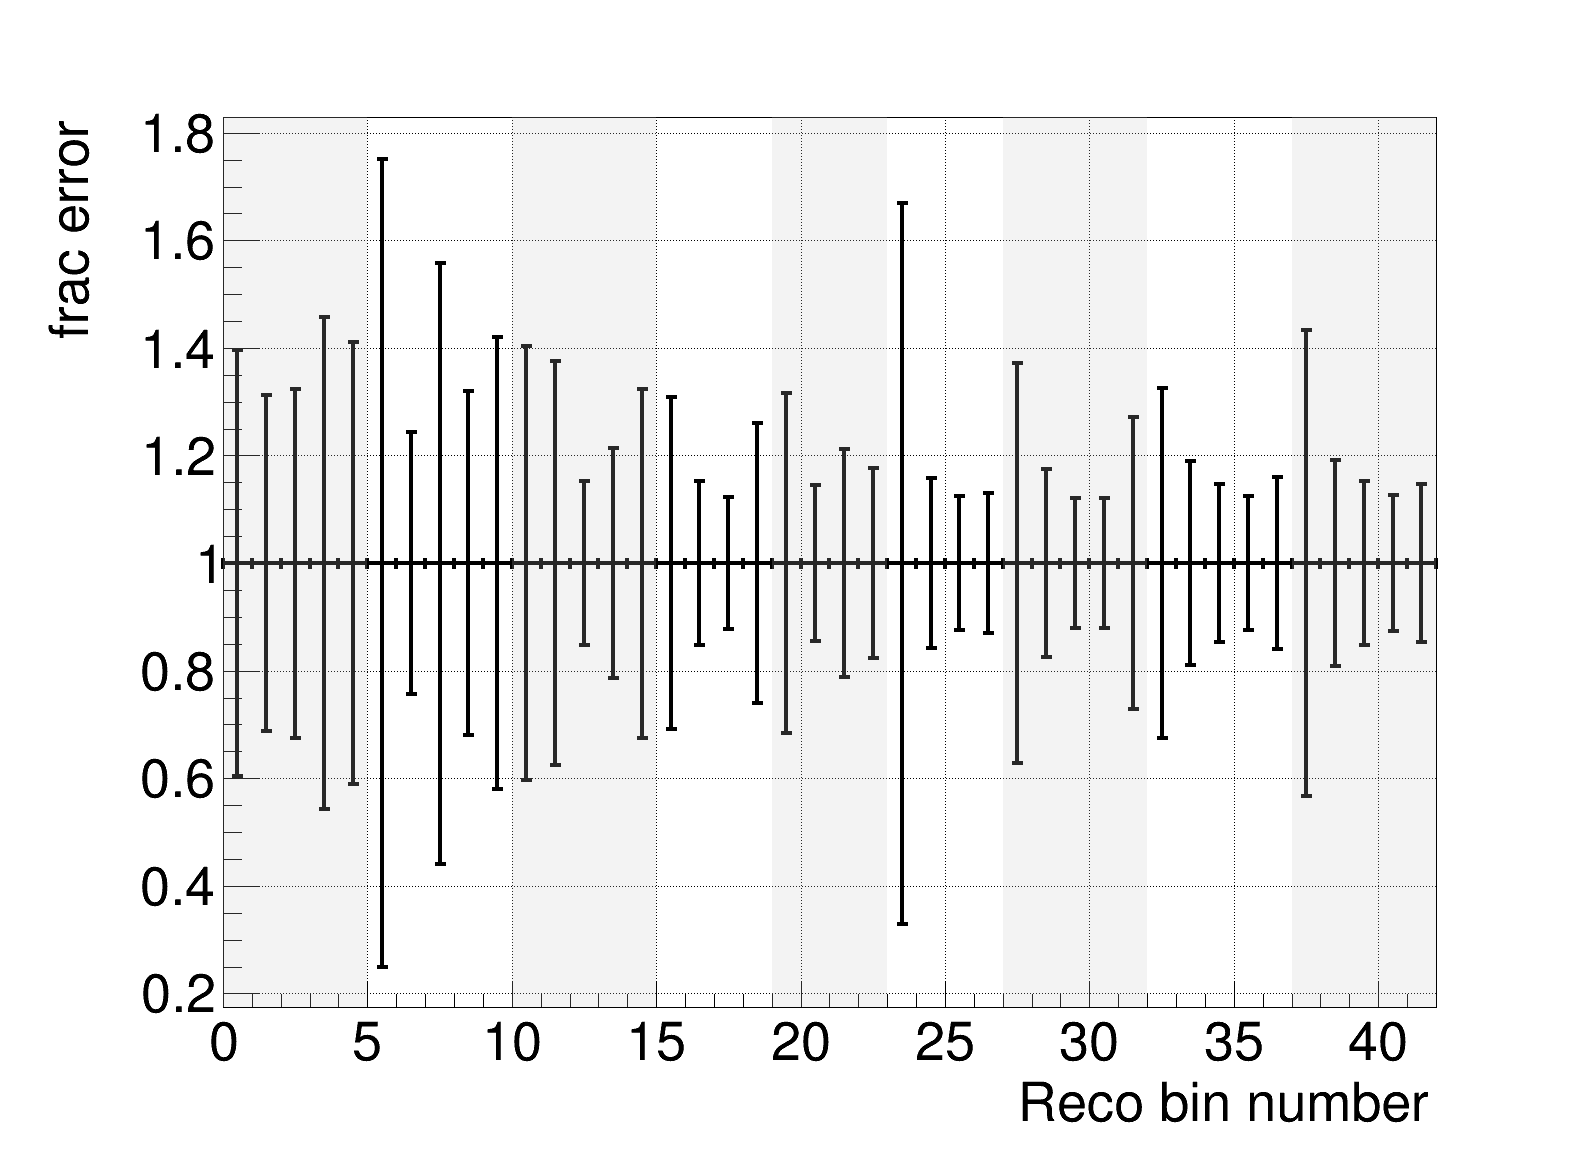

In [96]:
err = np.zeros((43))
for i in range(43):
    err[i] = math.sqrt(frac_tot[i][i])
h_err = FF.plot_err_array(err)
h_histo = FF.histBkg(h_err)
h_err.Draw('E1')
h_histo.Draw('hist same')
c1.Draw()

In [97]:
#smear true:
h_smear = f_cv.Get('h_smearing')
smear_mat = FF.plot2arr(h_smear,2)
eff_vec = FF.plot2arr(h_eff,1)
true_vec = FF.plot2arr(h_true,1)
#eff2 = eff_vec.T
smear_mat = smear_mat*eff_vec
reco_vec = true_vec.dot(smear_mat)
ROOT.gStyle.SetPaintTextFormat('0.1f')
h_reco = FF.arr2plot(reco_vec)
#h_reco.Scale(10)
h_reco.Draw('colz')
#c1.Draw()

[43. 43.]


Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


[43. 43.]
[[ 1.16329640e+03  3.56355117e+03  1.98360178e+03 ...  4.67879556e+03
   2.06862415e+03  7.86795687e+01]
 [ 3.56355117e+03  1.85854984e+04  9.84860601e+03 ...  2.11302447e+04
   1.02238105e+04 -5.10338867e+01]
 [ 1.98360178e+03  9.84860601e+03  5.84934565e+03 ...  1.06166370e+04
   5.95369235e+03 -2.24439967e+01]
 ...
 [ 4.67879556e+03  2.11302447e+04  1.06166370e+04 ...  8.13102362e+04
   2.74309891e+04  3.07165919e+02]
 [ 2.06862415e+03  1.02238105e+04  5.95369235e+03 ...  2.74309891e+04
   2.03755133e+04 -3.00041027e+02]
 [ 7.86795687e+01 -5.10338867e+01 -2.24439967e+01 ...  3.07165919e+02
  -3.00041027e+02  1.16663490e+02]]


Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_this (Potential memory leak).


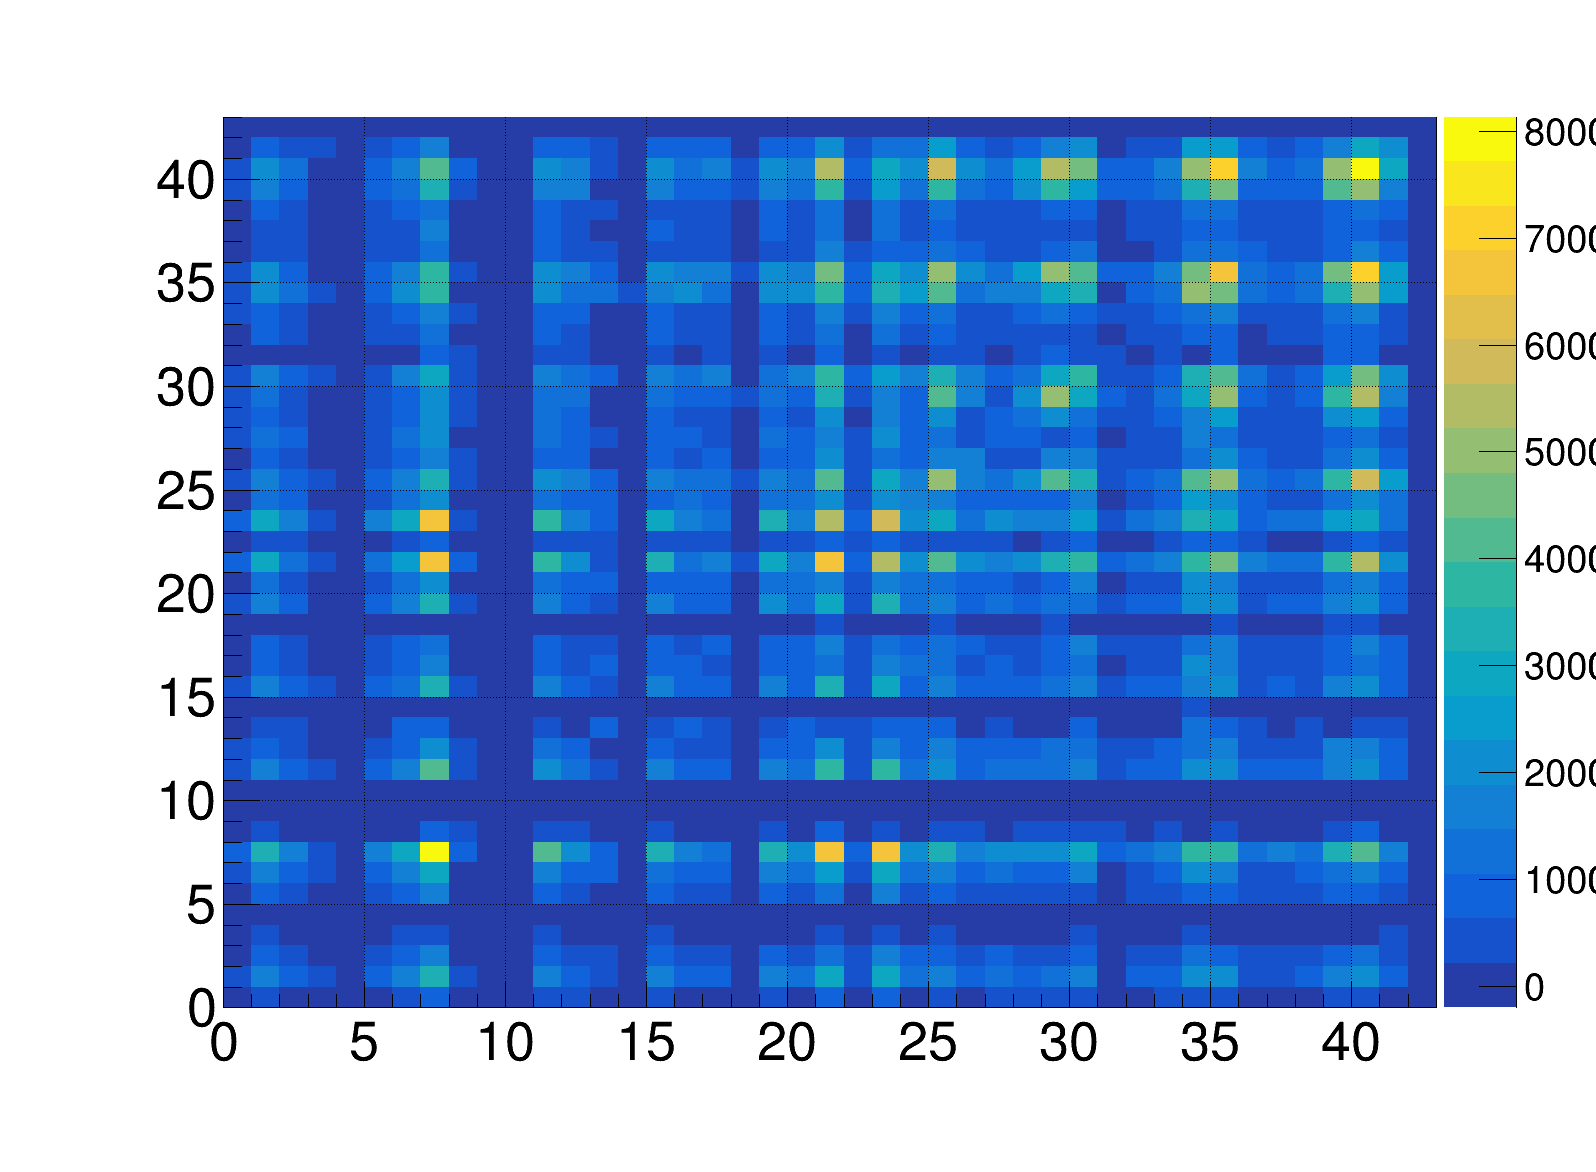

In [98]:
h_frac = FF.arr2plot(frac_tot)
h_frac.Draw('colz')
c1.Draw()

corr = FF.cov2corr(frac_tot)
h_reco = smear_plot(h_true)
reco_vec = FF.plot2arr(h_reco,1)
covar = FF.frac2cov(frac_tot,reco_vec)
print covar
h_covar = FF.arr2plot(covar)
h_covar.Draw('colz')
c1.Draw()

In [99]:
def eventrate_comparison(h_data_func,h_ext_func,h_dirt_func,h_bkg_func,h_true_func, filename,model_name):
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)

    c1.cd()

    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)

    FF.main_plot(h_data_func)
    
    h_reco_func = smear_plot(h_true_func)

    hs = ROOT.THStack("hs","");
    h_ext_func.SetFillColor(ROOT.kBlue+2)
    h_ext_func.SetLineColor(ROOT.kBlue+2)
    h_ext_func.SetFillStyle(3004)
    h_dirt_func.SetFillColor(ROOT.kOrange+2);
    h_dirt_func.SetLineColor(ROOT.kOrange+2);
    h_bkg_func.SetFillColor(ROOT.kGray)
    h_bkg_func.SetLineColor(ROOT.kGray)
    h_reco_func.SetFillColor(ROOT.kRed)
    h_reco_func.SetLineColor(ROOT.kRed)
    hs.Add(h_ext_func)
    hs.Add(h_dirt_func)
    hs.Add(h_bkg_func)
    hs.Add(h_reco_func)

    h_data_func.SetXTitle("Reco bin number")
    h_data_func.SetYTitle("Number of events")

    h_tot = h_reco_func.Clone()
    h_tot.Add(h_bkg_func)
    h_tot.Add(h_ext_func)
    h_tot.Add(h_dirt_func)
    
    num_bins = 43 # get eventually better than hardcode
    for i in range(num_bins):
        h_tot.SetBinError(i+1,math.sqrt(frac_tot[i][i])*h_tot.GetBinContent(i+1))
    pred_vec = FF.plot2arr(h_tot,1)
    
    #h_tot.Add(h_ext_func)
    #h_tot.Add(h_dirt_func)
    h_tot.SetFillColor(ROOT.kBlack)
    h_tot.SetLineColor(ROOT.kBlack)
    h_tot.SetFillStyle(3004)
    
    # calculate CHi2
    dat_vec = FF.plot2arr(h_data_func,1)
    dat_vec = dat_vec[0:-1]
    tot_vec = FF.plot2arr(h_tot,1)
    tot_vec = tot_vec[0:-1]
    covar = np.zeros((num_bins-1,num_bins-1))
    #get covar on signal+bkg
    for i in range(num_bins-1):
        for j in range(num_bins-1):
            covar[i][j] = frac_tot[i][j]*pred_vec[i]*pred_vec[j]
    
    #get stat data covar:
    #covar_data = np.zeros((num_bins-1,num_bins-1))
    #for i in range(num_bins-1):
    #    covar_data[i][i] = frac_stat[i][i]*dat_vec[i]*dat_vec[i]
    
    # get dirt uncertainty (100%)
    #covar_dirt = np.zeros((num_bins-1,num_bins-1))
    #pred_vec_all = FF.plot2arr(h_tot,1)
    #for i in range(num_bins-1):
    #    for j in range(num_bins-1):
    #        covar_dirt[i][j] = frac_dirt[i][j]*pred_vec_all[i]*pred_vec_all[j]
    
    # get crt uncertainty
    #covar_crt = np.zeros((num_bins-1,num_bins-1))
    #for i in range(num_bins-1):
    #    for j in range(num_bins-1):
    #        covar_crt[i][j] = frac_crt[i][j]*pred_vec_all[i]*pred_vec_all[j]
    
    
    #covar+=covar_data+covar_dirt+covar_crt
    #inv_covar = sla.inv(covar,check_finite=False)
    inv_covar = np.linalg.inv(covar)
    diff_vec = (dat_vec - tot_vec)
    #chi2_tmp = diff_vec.dot(inv_covar)
    #chi2 = chi2_tmp.dot(diff_vec)
    chi2 = 0.0
    for i in range(42):
        for j in range(42):
            chi2 += diff_vec[i]*inv_covar[i][j]*diff_vec[j]
        
    #print 'Data: ',dat_vec
    #print 'pred: ',tot_vec
    #print 'diff: ',diff_vec
    #print 'covar: ',covar
    #print 'inv covar: ',inv_covar
    #print chi2_tmp, chi2_tmp.shape
    print 'Chi2 = ',chi2
    h_data_func.SetMaximum(-1111)
    h_data_func.SetMaximum(h_data_func.GetMaximum()*1.2)
    h_data_func.Draw('E1')
    h_histo = FF.histBkg(h_err)
    h_histo.Draw('hist same')
    hs.Draw('same hist')
    h_tot.Draw('same E2')
    
    legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
    legend.AddEntry(h_data_func,'Data + stat.',"lep");
    legend.AddEntry(h_tot,model_name+' + bkg: #chi^{2}:'+'{:04.1f})'.format(chi2),"f");
    #legend.AddEntry(h_tot,'Syst. error, #chi^{2}:'+'{:04.1f})'.format(chi2),"f");
    legend.Draw()
    
    h_data_func.Draw('E1 same')

    prelim, pot_tex = FF.draw_adding()
    prelim.Draw()
    pot_tex.Draw()

    h_data_func.GetYaxis().SetTitleOffset(1);
    h_data_func.GetXaxis().SetLabelOffset(999);
    h_data_func.GetXaxis().SetTitleOffset(999);
    h_data_func.GetXaxis().SetLabelSize(0);
    h_data_func.GetXaxis().SetTitleSize(0);
    
    c1.cd()
    h_data_func.GetXaxis().SetLabelOffset(0);
    h_data_func.GetXaxis().SetTitleOffset(0);

    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    h_tot_noerr = h_tot.Clone()
    for i in range(43):
        h_tot_noerr.SetBinError(i,0)
    h_xsec_data_ratio = h_data_func.Clone()
    h_xsec_data_ratio.Divide(h_tot_noerr)
    h_mc_ratio = h_tot.Clone()
    h_mc_ratio.Divide(h_tot_noerr)

    h_xsec_data_ratio.SetYTitle('Data/(Ext+MC)')
    h_xsec_data_ratio.GetYaxis().SetTitleSize(0.1)
    h_xsec_data_ratio.GetYaxis().SetTitleOffset(0.3)
    h_xsec_data_ratio.GetYaxis().SetLabelSize(0.07)
    h_xsec_data_ratio.GetXaxis().SetTitleSize(0.15)
    h_xsec_data_ratio.GetXaxis().SetLabelSize(0.15)
    h_xsec_data_ratio.GetXaxis().SetTitleOffset(1)
    h_xsec_data_ratio.SetMaximum(2)
    h_xsec_data_ratio.Draw('E1')
    h_histo.Draw('hist same')
    h_mc_ratio.Draw('E2 same')

    c1.Draw()
    c1.SaveAs(outputdir_png + filename+".png")
    c1.SaveAs(outputdir_root + filename+".root")
    c1.SaveAs(outputdir_pdf + filename+".pdf")

    return


In [100]:
path_gen = '/home/tmettler/Desktop/uBoone/Nuisance/root_trees/'
f_g3 = ROOT.TFile.Open(path_gen+"ccinc_2d_genie3.root", 'read')
f_g2 = ROOT.TFile.Open(path_gen+"ccinc_2d_genie2.root", 'read')
f_gibuu = ROOT.TFile.Open(path_gen+"ccinc_2d_gibuu.root", 'read')
f_neut = ROOT.TFile.Open(path_gen+"ccinc_2d_neut.root", 'read')
f_nuwro = ROOT.TFile.Open(path_gen+"ccinc_2d_nuwro.root", 'read')

h_xsec_g3 = f_g3.Get('MicroBooNE_CCInc_XSec_2DPcos_nu_MC;1')
h_xsec_g2 = f_g2.Get('MicroBooNE_CCInc_XSec_2DPcos_nu_MC')
h_xsec_gibuu = f_gibuu.Get('MicroBooNE_CCInc_XSec_2DPcos_nu_MC')
h_xsec_neut = f_neut.Get('MicroBooNE_CCInc_XSec_2DPcos_nu_MC')
h_xsec_nuwro = f_nuwro.Get('MicroBooNE_CCInc_XSec_2DPcos_nu_MC')

#print f_g3.ls()
#h_true_g3.Draw()
#c1.Draw()

In [101]:
def xsec2rate(h_true):
    #xsec to event rate:
    # need pot/flux, xsec
    h_rate = h_true.Clone()
    bin_counter = 0
    for t_bin in range(len_theta): #len_theta
        h_temp = f_cv.Get('h_data['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            bin_width =  h_temp.GetBinWidth(m_bin+1)
            bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
            h_rate.SetBinContent(bin_counter,h_rate.GetBinContent(bin_counter)*(bin_width*bin_width_theta))
            h_rate.SetBinError(bin_counter,h_rate.GetBinError(bin_counter)*(bin_width*bin_width_theta))
    h_rate.Scale(N_tot*flux_cv)
    return h_rate

In [102]:
#h_reco_rate = smear_plot(h_rate)

h_rate_g3 = xsec2rate(h_xsec_g3)
h_rate_g2 = xsec2rate(h_xsec_g2)
h_rate_gibuu = xsec2rate(h_xsec_gibuu)
h_rate_neut = xsec2rate(h_xsec_neut)
h_rate_nuwro = xsec2rate(h_xsec_nuwro)

In [103]:
#inv = np.linalg.inv(frac_tot)

In [104]:
'''data_arr = FF.plot2arr(h_data,1)
#print data_arr
bkg_arr = FF.plot2arr(h_bkg,1)
#print bkg_arr
true_arr = FF.plot2arr(h_true,1)
#print true_arr
reco_arr = FF.plot2arr(h_reco,1)
#print reco_arr
pred_vec = bkg_arr+reco_arr
covar = np.zeros((42,42))
for i in range(42):
        for j in range(42):
            covar[i][j] = frac_tot[i][j]*pred_vec[i]*pred_vec[j]
inv = np.linalg.inv(covar)
inv = FF.arr2plot(covar)
inv.Draw('colz')
c1.Draw()
print covar[:][41]'''

"data_arr = FF.plot2arr(h_data,1)\n#print data_arr\nbkg_arr = FF.plot2arr(h_bkg,1)\n#print bkg_arr\ntrue_arr = FF.plot2arr(h_true,1)\n#print true_arr\nreco_arr = FF.plot2arr(h_reco,1)\n#print reco_arr\npred_vec = bkg_arr+reco_arr\ncovar = np.zeros((42,42))\nfor i in range(42):\n        for j in range(42):\n            covar[i][j] = frac_tot[i][j]*pred_vec[i]*pred_vec[j]\ninv = np.linalg.inv(covar)\ninv = FF.arr2plot(covar)\ninv.Draw('colz')\nc1.Draw()\nprint covar[:][41]"

[43. 43.]
Chi2 =  349.2299659604477
[43. 43.]
Chi2 =  576.8695445147608
[43. 43.]
Chi2 =  589.868252935784
[43. 43.]
Chi2 =  587.3975472469739
[43. 43.]
Chi2 =  436.7914595929877
[43. 43.]
Chi2 =  510.47385139377616


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/png/event_rate_G3_tune.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/root/event_rate_G3_tune.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/pdf/event_rate_G3_tune.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/png/event_rate_G3.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/root/event_rate_G3.root has b

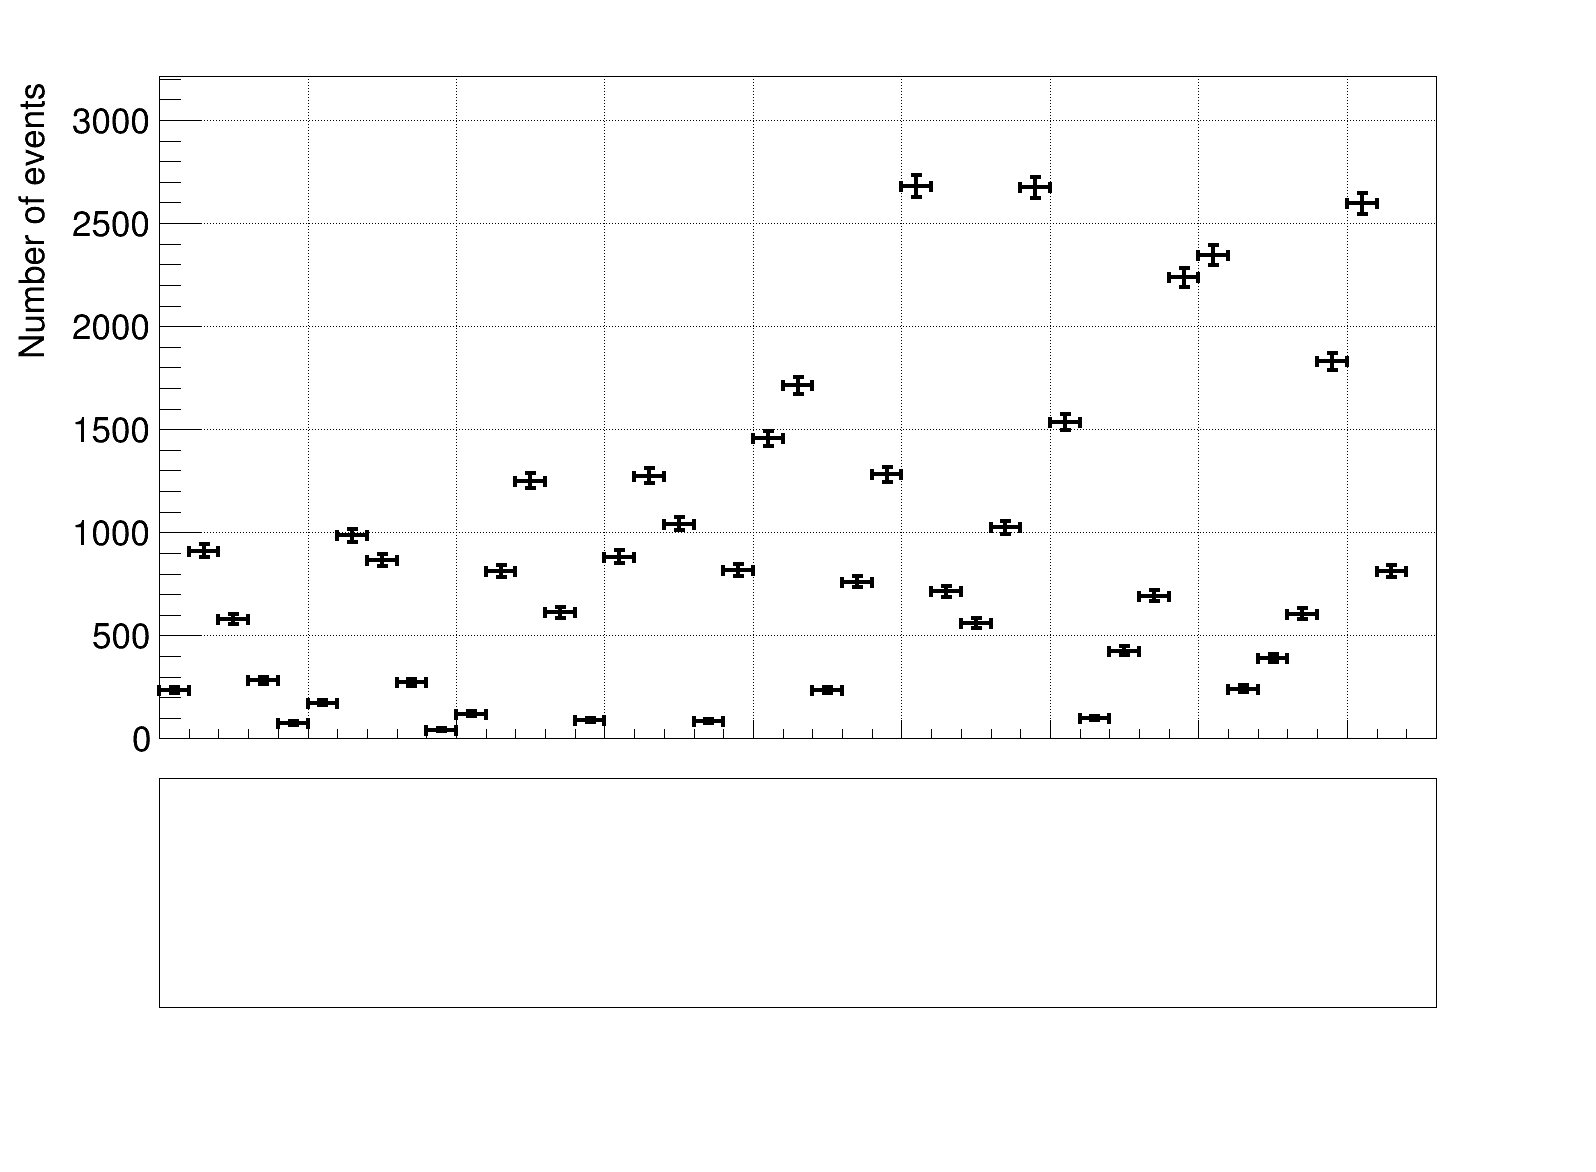

In [105]:
eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_true, 'event_rate_G3_tune','G3 uB tune')

eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_rate_g3, 'event_rate_G3','G3')
eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_rate_g2, 'event_rate_G2','G2')
eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_rate_gibuu, 'event_rate_gibuu','GiBuu')
eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_rate_neut, 'event_rate_neut','Neut')
eventrate_comparison(h_data,h_ext,h_dirt,h_bkg,h_rate_nuwro, 'event_rate_nuwro','NuWro')


In [106]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Chi2 =  591.011373859666


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/png/xsec.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/root/xsec.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/improved_ff/pdf/xsec.pdf has been created


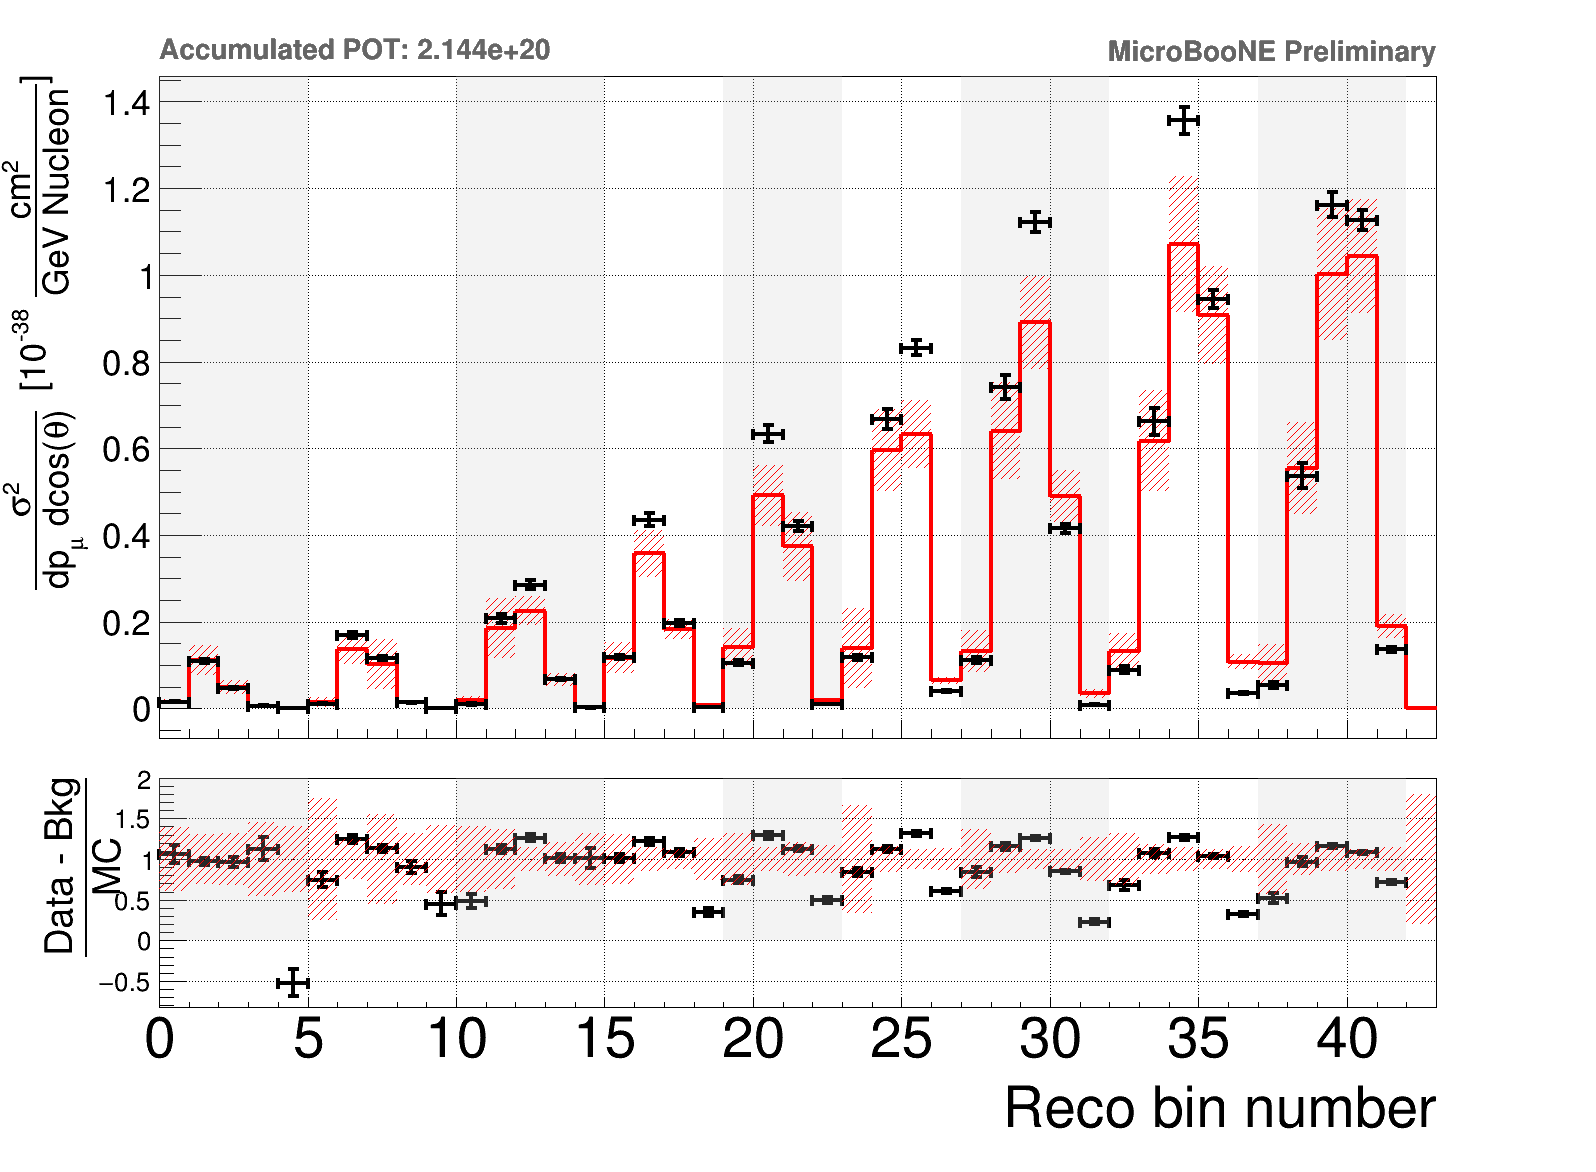

In [107]:
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)

c1.cd()

pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)

h_xsec_data = h_data.Clone()
h_xsec_data.Add(h_ext,-1)
h_xsec_data.Add(h_dirt,-1)
h_xsec_data.Add(h_bkg,-1)

num_bins = h_xsec_data.GetNbinsX()

h_xsec_data.Scale(1.0/(N_tot*flux_cv*1e-38))

h_xsec_reco = h_reco.Clone()

for i in range(43):
    h_xsec_reco.SetBinError(i+1,math.sqrt(frac_tot[i][i])*(h_reco.GetBinContent(i+1)))#+h_bkg.GetBinContent(i+1)))
    
h_xsec_reco.Scale(1.0/(N_tot*flux_cv*1e-38))

bin_counter = 0
for t_bin in range(len_theta): #len_theta
    h_temp = f_cv.Get('h_data['+str(t_bin)+']')
    for m_bin in range(len_mom[t_bin]):
        bin_counter+=1
        bin_width =  h_temp.GetBinWidth(m_bin+1)
        bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
        h_xsec_data.SetBinContent(bin_counter,h_xsec_data.GetBinContent(bin_counter)/(bin_width*bin_width_theta))
        h_xsec_data.SetBinError(bin_counter,h_xsec_data.GetBinError(bin_counter)/(bin_width*bin_width_theta))
        h_xsec_reco.SetBinContent(bin_counter,h_xsec_reco.GetBinContent(bin_counter)/(bin_width*bin_width_theta))
        h_xsec_reco.SetBinError(bin_counter,h_xsec_reco.GetBinError(bin_counter)/(bin_width*bin_width_theta))
#here

pred_vec = FF.plot2arr(h_xsec_reco,1)

# calculate CHi2
dat_vec = FF.plot2arr(h_xsec_data,1)
dat_vec = dat_vec[0:-1]
tot_vec = FF.plot2arr(h_xsec_reco,1)
tot_vec = tot_vec[0:-1]
covar = np.zeros((num_bins-1,num_bins-1))

for i in range(num_bins-1):
    for j in range(num_bins-1):
        covar[i][j] = frac_tot[i][j]*tot_vec[i]*tot_vec[j]
#covar = covar
#inv_covar = sla.inv(covar,check_finite=False)
inv_covar = np.linalg.inv(covar)
diff_vec = (dat_vec - tot_vec)
#chi2_tmp = diff_vec.dot(inv_covar)
#chi2 = chi2_tmp.dot(diff_vec)
chi2 = 0.0
for i in range(42):
    for j in range(42):
        #if(i!=4 and i!=9 and j!=4 and j!=9):
        tmp = diff_vec[i]*inv_covar[i][j]*diff_vec[j]
        chi2+= tmp
        #print diff_vec[i],diff_vec[j],inv_covar[i][j],tmp
#print 'Data: ',dat_vec
#print 'pred: ',tot_vec
#print 'diff: ',diff_vec
#print 'covar: ',covar
#print 'inv covar: ',inv_covar
#print chi2_tmp, chi2_tmp.shape
print 'Chi2 = ',chi2    
        

h_xsec_data.SetXTitle("Reco bin number")
h_xsec_data.SetYTitle("#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]")


h_xsec_reco.SetFillColor(ROOT.kRed)
h_xsec_reco.SetLineColor(ROOT.kRed)
h_xsec_reco.SetFillStyle(3004)
h_xsec_data.Draw('E1')
h_histo = FF.histBkg(h_err)
h_histo.Draw('hist same')
h_xsec_reco.Draw('same E2')
h_xsec_reco2 = h_xsec_reco.Clone()
h_xsec_reco2.SetFillColor(0)
h_xsec_reco2.Draw('same hist')

h_xsec_data.Draw('E1 same')

pot_data = 2.144e+20
prelim, pot_tex = FF.draw_adding()
prelim.Draw()
pot_tex.Draw()

h_xsec_data.GetYaxis().SetTitleOffset(0.9);
h_xsec_data.GetXaxis().SetLabelOffset(999);
h_xsec_data.GetXaxis().SetTitleOffset(999);
h_xsec_data.GetXaxis().SetLabelSize(0);
h_xsec_data.GetXaxis().SetTitleSize(0);

c1.cd()
h_xsec_data.GetXaxis().SetLabelOffset(0);
h_xsec_data.GetXaxis().SetTitleOffset(0);

pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
pad2.Draw()
pad2.cd()
h_tot_noerr = h_xsec_reco.Clone()
for i in range(43):
    h_tot_noerr.SetBinError(i,0)
h_xsec_data_ratio = h_xsec_data.Clone()
h_xsec_data_ratio.Divide(h_tot_noerr)
h_mc_ratio = h_xsec_reco.Clone()
h_mc_ratio.Divide(h_tot_noerr)
#frac{Data - Bkg}{MC}
h_xsec_data_ratio.SetYTitle('#frac{Data - Bkg}{MC}')
h_xsec_data_ratio.GetYaxis().SetTitleSize(0.1)
h_xsec_data_ratio.GetYaxis().SetTitleOffset(0.3)
h_xsec_data_ratio.GetYaxis().SetLabelSize(0.07)
h_xsec_data_ratio.GetXaxis().SetTitleSize(0.15)
h_xsec_data_ratio.GetXaxis().SetLabelSize(0.15)
h_xsec_data_ratio.GetXaxis().SetTitleOffset(1)
h_xsec_data_ratio.SetMaximum(2)
h_xsec_data_ratio.Draw('E1')
h_histo.Draw('hist same')

h_mc_ratio.Draw('E2 same')

c1.Draw()
c1.SaveAs(outputdir_png + "xsec.png")
c1.SaveAs(outputdir_root + "xsec.root")
c1.SaveAs(outputdir_pdf + "xsec.pdf")


In [108]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kFALSE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [109]:
keepRow = [1,2,4,8]
m = TMatrixD(4,4)
for i in range(len(keepRow)):
    ROOT.TMatrixDColumn(m,i) = ROOT.TMatrixDColumn(m,keepRow[i]);
m.ResizeTo(keepRow.GetSize(),nCol);

SyntaxError: can't assign to function call (<ipython-input-109-ddc40874830d>, line 4)

In [110]:
h_inv = h_covar.Clone()
print h_covar.GetNbinsX()
arr = h_inv.GetArray()
#print arr[0][0],arr[1][1],arr[42]
mymatrix = ROOT.TMatrix(42+2,42+2,h_inv.GetArray(),"F")
#a = array('I',[1])
test = ROOT.TMatrix(42,42)
test.SetSub(0,0,5)
#for i in range(42):
#    for j in range(42):
#        ROOT.TMatrixDElement(test,i,j)=h_covar[i][j]
#test[0][0] = 10
#ROOT.Math.SMatrix.Invert(h_inv)
print mymatrix[17][19]
#my_test = mymatrix.Invert()
test_arr = ROOT.TMatrix(42,42,test,'F')

43


TypeError: TMatrixTBase<float>& TMatrixT<float>::SetSub(int row_lwb, int col_lwb, const TMatrixTBase<float>& source) =>
    could not convert argument 3

In [111]:
def getMatrixMinor(m,i,j):
    return [row[:j] + row[j+1:] for row in (m[:i]+m[i+1:])]

def getMatrixDeternminant(m):
    #base case for 2x2 matrix
    if len(m) == 2:
        return m[0][0]*m[1][1]-m[0][1]*m[1][0]

    determinant = 0
    for c in range(len(m)):
        determinant += ((-1)**c)*m[0][c]*getMatrixDeternminant(getMatrixMinor(m,0,c))
    return determinant

def getMatrixInverse(m):
    determinant = getMatrixDeternminant(m)
    #special case for 2x2 matrix:
    if len(m) == 2:
        return [[m[1][1]/determinant, -1*m[0][1]/determinant],
                [-1*m[1][0]/determinant, m[0][0]/determinant]]

    #find matrix of cofactors
    cofactors = []
    for r in range(len(m)):
        cofactorRow = []
        for c in range(len(m)):
            minor = getMatrixMinor(m,r,c)
            cofactorRow.append(((-1)**(r+c)) * getMatrixDeternminant(minor))
        cofactors.append(cofactorRow)
    cofactors = transposeMatrix(cofactors)
    for r in range(len(cofactors)):
        for c in range(len(cofactors)):
            cofactors[r][c] = cofactors[r][c]/determinant
    return cofactors

In [112]:
from sympy.matrices import Matrix
#inv = getMatrixInverse(covar)

ImportError: No module named sympy.matrices

-4.474563655277812e-06


Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_this (Potential memory leak).


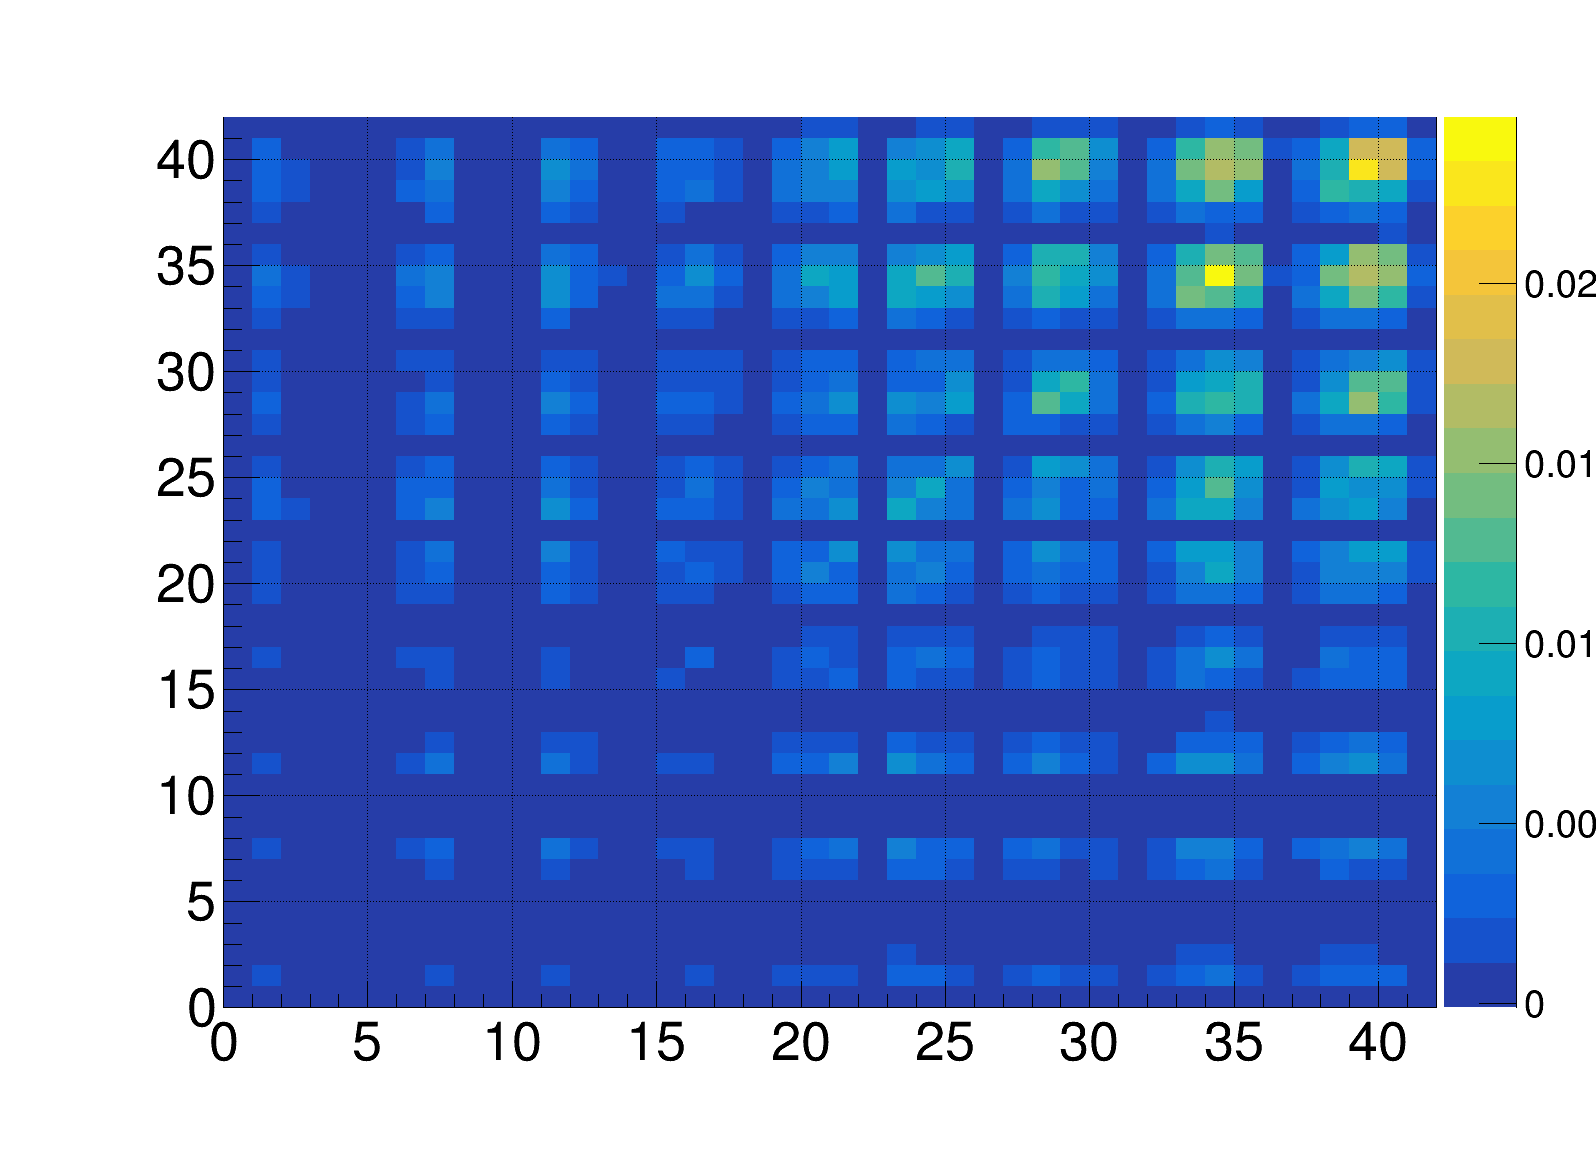

In [113]:
#tot_xsec = FF.plot2arr(h_xsec_reco,1)
#covar = FF.frac2cov(frac_tot,tot_xsec)
#print covar
print covar[16][18]
h_covar = FF.arr2plot(covar)
h_covar.Draw('colz')
c1.Draw()

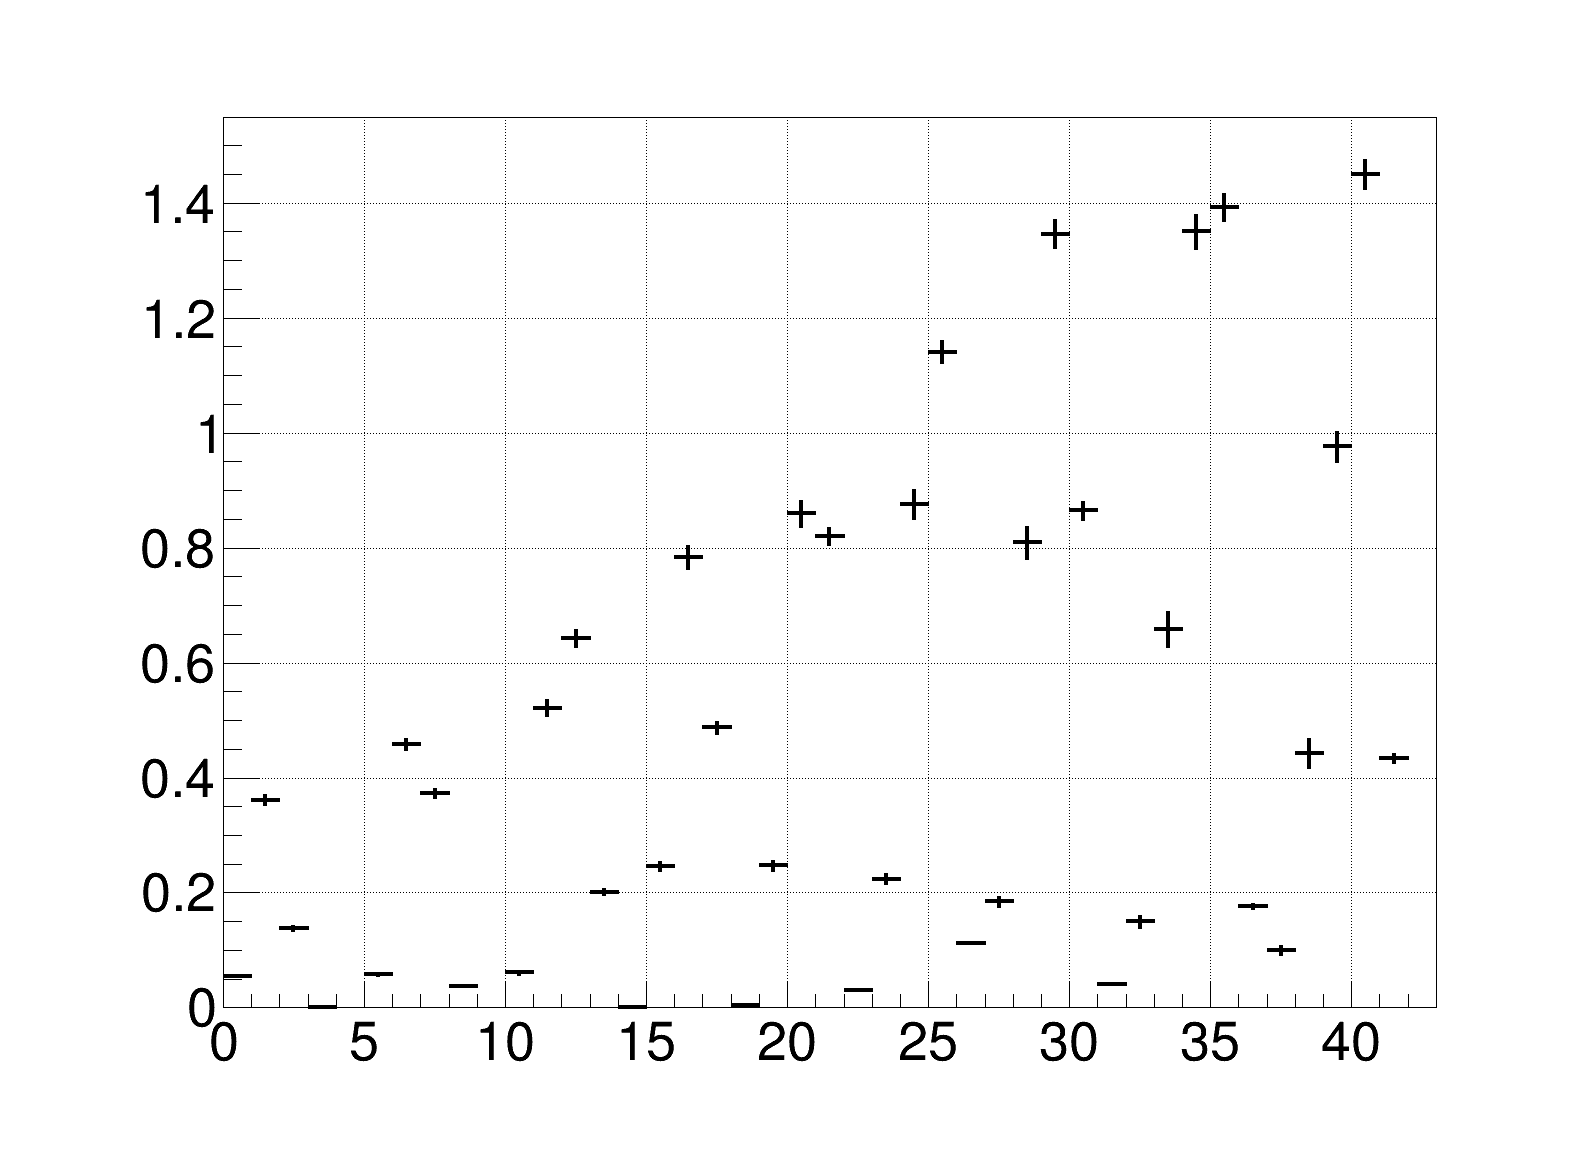

In [114]:
FF.main_plot(h_true)
h_xsec_true = h_true.Clone()


h_xsec_true.Scale(1.0/(N_tot*flux_cv*1e-38))

bin_counter = 0
for t_bin in range(len_theta): #len_theta
    h_temp = f_cv.Get('h_data['+str(t_bin)+']')
    for m_bin in range(len_mom[t_bin]):
        bin_counter+=1
        bin_width =  h_temp.GetBinWidth(m_bin+1)
        bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
        h_xsec_true.SetBinContent(bin_counter,h_xsec_true.GetBinContent(bin_counter)/(bin_width*bin_width_theta))
        h_xsec_true.SetBinError(bin_counter,h_xsec_true.GetBinError(bin_counter)/(bin_width*bin_width_theta))

h_xsec_true.Draw()
c1.Draw()

In [115]:
h_true_cv = h_true.Clone()
    h_bkg_cv = f_flux_bkg[0].Get('h_bkg_all[0][0]')
    bin_counter=0
    for t_bin in range(len_theta): #len_theta
        h_temp = f_flux_bkg[0].Get('h_overlay_cv['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_bkg_cv.SetBinContent(bin_counter,h_temp.GetBinContent(m_bin+1))
    
    h_bkg_cv.Scale(this_pot/7.644e+18)
    h_smear_cv = f_flux_smear[0].Get('h_smearing_cv')
    h_eff_cv = f_flux_bkg[0].Get('h_eff_all_cv')
    h_eff_cv.SetBinContent(5,1)
    h_eff_cv.SetBinContent(10,1)
    
    path_ext = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_filesV4/'
    f_ext = ROOT.TFile.Open(path_ext+'xsec_2D_Run3_wighted.root', 'read')
    h_ext = ROOT.TH1F('h_ext',"Cosmic",43,0,43)
    h_dirt = ROOT.TH1F('h_dirt',"Cosmic",43,0,43)
    bin_counter = 0
    for t_bin in range(len_theta): #len_theta
        h_temp4 = f_cv.Get('h_ext['+str(t_bin)+']')
        h_temp5 = f_cv.Get('h_dirt['+str(t_bin)+']')
        for m_bin in range(len_mom[t_bin]):
            bin_counter+=1
            h_ext.SetBinContent(bin_counter,h_temp4.GetBinContent(m_bin+1))
            h_dirt.SetBinContent(bin_counter,h_temp5.GetBinContent(m_bin+1))
    h_ext.Scale(this_pot/2.144e+20)
    h_dirt.Scale(this_pot/2.144e+20)
    
    num_bins = h_smear_cv.GetNbinsX()
    smear_mat = np.zeros((num_bins,num_bins))
    true_vec = np.zeros((num_bins))
    bkg_vec = np.zeros((num_bins))
    ext_vec = np.zeros((num_bins))
    dirt_vec = np.zeros((num_bins))

    for i in range(num_bins):
        true_vec[i] = h_true_cv.GetBinContent(i+1)
        bkg_vec[i] = h_bkg_cv.GetBinContent(i+1)
        ext_vec[i] = h_ext.GetBinContent(i+1)
        dirt_vec[i] = h_dirt.GetBinContent(i+1)
        for j in range(num_bins):
            smear_mat[i][j]= h_smear_cv.GetBinContent(i+1,j+1)*h_eff_cv.GetBinContent(j+1)

    reco_vec = true_vec.dot(smear_mat)

IndentationError: unexpected indent (<ipython-input-115-43d1d4469bbf>, line 2)